In [1]:
import numpy as np

from numba import *
from numbapro import vectorize

#para cambiar el eje y 
from matplotlib import ticker
import matplotlib.pyplot as plt

from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 20
rcParams['axes.labelsize']=25
rcParams['axes.titlesize']=25
rcParams['legend.fontsize']=20

%matplotlib inline

import time

from trasferencia_calor import solve_explicit, explicit_numba, \
                                explicit_py, explicit_slicing, pretty_plot

In [92]:
def solve_explicit(z_total=35000, dz=1750, t_total=3.1536e14, dt=3.1536e8, T0=727, 
                  kappa=1e-6, A0=2e-6, p=5500, C=1260, L=10000, CFL=0.5, 
                  amount_plot = 2, metodo = 'explicit_slicing'):
    '''Solucion numerica de la ecuacion de difusion de calor
    
    Los numero de puntos en la grilla temporal (nt) son calculados teniendo en cuenta que se 
    cumpla la ecuacion de estabilidad
    
    Parameters
    ----------
    z_total  : integer
        profundidad total. [z] = m.
    dz : float
        Paso en la dimención Z. [dz] = m.
    t_total : float
        tiempo total de calculo. [t_total] = s.
    dt : float
        Paso en el tiempo. De no cumplir con la ecuacion de estavilidad, 
          se lo recalculara. [dt] = s.
    T0 : float
        Temperatura en z. [T0] = K.
    kappa : float
        Difusion termica. [kappa] = m2/s.
    A0 : float
        Volumetric heat production rate. [A0] = W/m3
    p : float
        Densidad. [p] = m3/Kg
    C : float
        Calor especifico. [C] = J/(Kg K)
    L : float
        Longitud caracteristica. [L] = m
    CFL: float
        Valor para la estavilidad de la ecuacion
    amount_plot : int
        Cantidad de plots x-espaciados
    metodo: str
        metodo con el cual se va a resolver la ED
        
    Returns
    -------
    u : array
        Array solucion del problema.
    prop: dictionary
        Algunas propiedades del problema (dz, dt, z, t_total, nx, nt)
    '''
    
    #Cálculo de cantidad de puntos en la dimensión Z (nz) como z_total/dz.
    #Chequeo que nz sea entero. De no serlo, recalculo z_total.
    if z_total%dz == 0:
        nz = z_total//dz
    else:
        z_total = z_total + (dz - z_total%dz)
        nz = z_total//dz
    
    #Chequeo que el dt ingresado cumpla con la ecuacion de estabilidad
    #Si no lo cumple, se lo recalcula
    condicion_cfl = dz**2/(2*kappa)
    if dt > condicion_cfl:
        dt = condicion_cfl
    
    #Cálculo de cantidad de puntos en la dimensión temporal (nt) como t_total/dt.
    #Chequeo que nt sea entero. De no serlo, recalculo t_total.
    if t_total%dt == 0:
        nt = int(t_total//dt)
    else:
        t_total = t_total + (dt - t_total%dt)
        nt = int(t_total//dt)
    
    #Inicialización de los array
    #Array de espacio
    z = np.array(range(0, z_total, dz))

    #Array solucion de la temp.
    u = np.zeros(nz)
    un = np.zeros(nz)
    #Condicion inicial
    u[-1] = T0
    
    #Como el ultimo termino del modelo no varia con el timepo
    #lo calculo antes y luego solo lo sumo vectorialmente
    const = (dt*A0)/(p*C)*np.exp(-z/L)
    
    prop = {}
    prop['dz'] = dz
    prop['dt'] = dt
    prop['z'] = z_total
    prop['t_total'] = t_total
    prop['nz'] = nz
    prop['nt'] = nt
    
    u_out = []
    
    
    if amount_plot <= 2:
        amount_plot = 2

    prop['amount_plot'] = amount_plot + 1
        
    plot_time = [int(i) for i in np.linspace(0, nt, amount_plot+1)]

    u_out.append(u.copy())
    '''
    for i in range(len(plot_time) - 1):
        print(u)
        for k in range(plot_time[i], plot_time[i+1]):
            un = u.copy()
            u_temp = explicit_vect(un[1:-1], un[2:], un[:-2], const[1:-1], kappa, dt, dz)
            u[1:-1] = u_temp
        u_out.append(u.copy())
    '''
    
    if metodo == 'explicit_py':
        for i in range(len(plot_time) - 1):
            for k in range(plot_time[i], plot_time[i+1]):
                u = explicit_py(u, kappa, dt, dz, const, nz)
            u_out.append(u.copy())
    
    elif metodo == 'explicit_numba':
        for i in range(len(plot_time) - 1):
            for k in range(plot_time[i], plot_time[i+1]):
                u = explicit_numba(u, kappa, dt, dz, const, nz)
            u_out.append(u.copy())
            
    elif metodo == 'explicit_vectorize':
        for i in range(len(plot_time) - 1):
            for k in range(plot_time[i], plot_time[i+1]):
                un = u.copy()
                u_temp = explicit_vect(un[1:-1], un[2:], un[:-2], const[1:-1], kappa, dt, dz)
                u[1:-1] = u_temp
            u_out.append(u.copy())
    
    elif metodo == 'explicit_slicing':
        for i in range(len(plot_time) - 1):
            for k in range(plot_time[i], plot_time[i+1]):
                u = explicit_slicing(u, kappa, dt, dz, const)
            u_out.append(u.copy())
    
    else:
        print('No existe ese metodo')
        return('No existe ese metodo')
    
    return u_out, prop

def pretty_plot(T_out, prop, marker_plot = '-'):
    ''' Pretty plot to show solution of solve_explicit
    
    Parameters
    ----------
    T_out : array
            Arrays de salida de solve_explicito
    prop : dictionary
            Diccionario con algunas propiedades de la solución numérica (dt, dz, z_total, etc)
            
    marker_plot : str
            Marcador para hacer el plot
            
    Returns
    -------
    Plot
    
    '''

    z = np.array(range(0, prop['z'], prop['dz']))

    fig, ax = plt.subplots(figsize=(12, 11))

    for i in range(len(T_out)):
        ax.plot(T_out[i], z, marker_plot, label=r'$time=%.2e$' % (prop['dt']*prop['nt'] * i))

    plt.xlabel('$T(K)$', fontsize=25)
    plt.ylabel(r'$z(m)$', fontsize=25)
    plt.title('$Heat\, conductions\; \Delta t=%.2e\; \Delta z=%.2e$' % \
              (prop['dt'], prop['dz']), fontsize=25)
    plt.legend(loc = "best", fontsize=20)

    #Para setear que el eje y sea en notacion cientifica
    ax.set_yticks([i for i in range(0, 40000, 5000)])

    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True) 
    formatter.set_powerlimits((-1,1)) 
    ax.yaxis.set_major_formatter(formatter)

    plt.grid(True)

In [105]:
@vectorize(['float32(float32, float32, float32, float32, float32, float32, float32)',
            'float64(float64, float64, float64, float64, float64, float64, float64)'], target='parallel')
def explicit_vect(un, un_plus_1, un_less_1, const, kappa, dt, dz):
    u_temp = un + kappa*dt/dz**2*(un_plus_1 - 2*un + un_less_1) + const
    return u_temp

a = time.time()
t_out, prop = solve_explicit(metodo='explicit_vectorize', amount_plot=10)
print('tiempo vectorizado: ', time.time() - a)
a = time.time()
t_out2, prop2 = solve_explicit(metodo='explicit_numba', amount_plot=10)
print('tiempo numba: ', time.time() - a)

KeyboardInterrupt: 

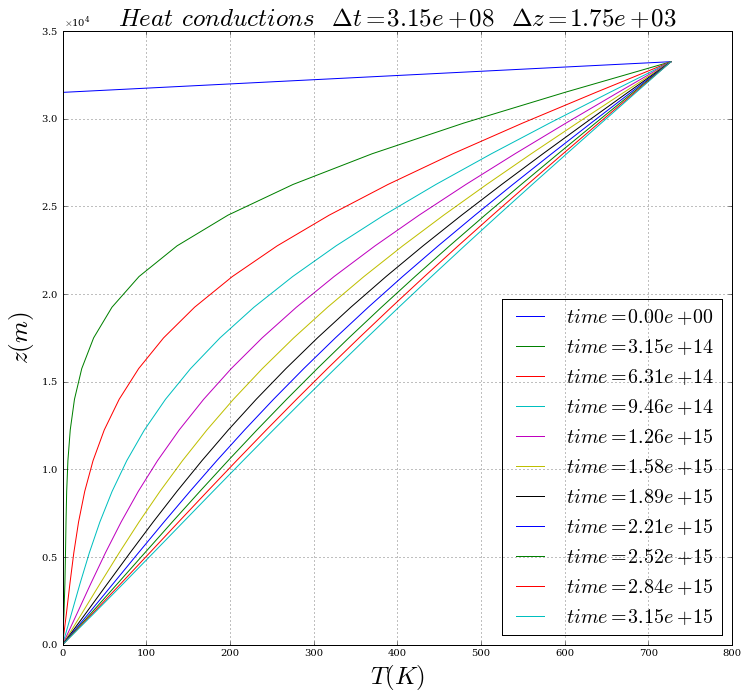

In [101]:
pretty_plot(t_out, prop)